# Planejamento de movimento em região livre

## Dinâmica

Consideramos: $m=2$, $\delta t=1$, $\text{Origem}=(0,0)$ e a seguinte dinâmica:
$$
\begin{pmatrix}
x_{k+1}\\
y_{k+1}\\
\dot{x}_{k+1}\\
\dot{y}_{k+1}
\end{pmatrix}
=
\begin{pmatrix}
1 & 0 & \Delta t & 0\\
0 & 1 & 0 & \Delta t\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
x_k\\
y_k\\
\dot{x}_k\\
\dot{y}_k
\end{pmatrix}
+
\begin{pmatrix}
\frac{1}{2}\frac{(\Delta t)^2}{m} & 0\\
0 & \frac{1}{2}\frac{(\Delta t)^2}{m}\\
\frac{\Delta t}{m} & 0\\
0 & \frac{\Delta t}{m}
\end{pmatrix}
\begin{pmatrix}
F_{x,k}\\
F_{y,k}
\end{pmatrix}.
$$

ou de forma um pouco mais compacta:

$$
A =
\begin{bmatrix}
I & \Delta t I\\
0 & I
\end{bmatrix}, \qquad
B =
\begin{bmatrix}
\tfrac{1}{2}\Delta t^2 I\\
\Delta t I
\end{bmatrix}\tfrac{1}{m},
$$

## Modelagem

Partindo do caso trivial onde o espaço livre é todo o plano:

$$
\begin{aligned}
\min \quad & C(x,u) \\
st. \quad & x_0=x_{start} \\
& x_N=x_{goal} \\
& x_{t+1}=Ax_t+Bu_t \quad \forall t \\
& x_t\in \R^2,\, u_t\in U_\text{Lim} \quad \forall t
\end{aligned}
$$

Então aproximamos a fronteira da região por um polígono $P$ com $m$ faces, obtendo o seguinte modelo:

$$
\begin{aligned}
    \min_{\{x_t,\,u_t\}} \quad & 
    C(x,u):=\sum_{t=0}^{N-1} \ell(x_t, u_t) \\
    \text{st.} \quad 
    & x_{t+1} = A x_t + B u_t, \quad t = 0, 1, \ldots, N-1, \\
    & h_i^{\mathsf{T}}x_t \leq g_i, \quad i = 1, 2, \ldots, m; \quad t = 0, 1, \ldots, N, \\
    & x_0 = x_{\text{start}}, \quad x_N = x_{\text{goal}}, \\
    & u_t \in U_{\text{Lim}},\quad x_t\in P \quad t = 0, 1, \ldots, N.
\end{aligned}
$$

Maior violação Hx<=g (deve ser <= 0): -1.130e+00


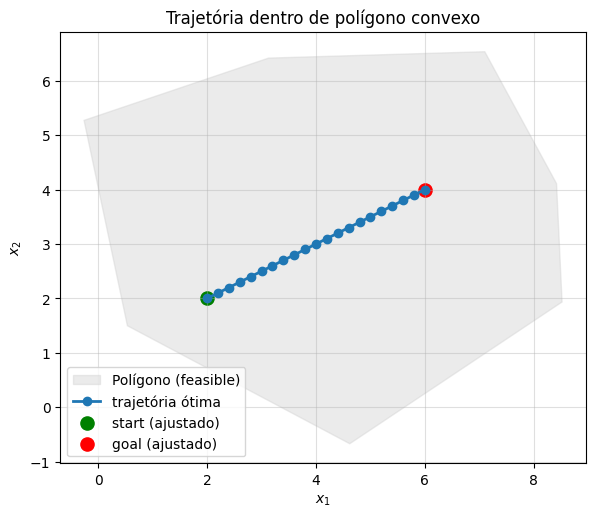

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum

# ---------------------
# util: H,g a partir de vértices CCW (normais "para fora")
# ---------------------
def polygon_Hg_from_vertices_ccw(V):
    H_list, g_list = [], []
    m = len(V)
    for i in range(m):
        p = V[i]
        q = V[(i+1) % m]
        e = q - p
        n = np.array([e[1], -e[0]], dtype=float)          # +90° da aresta (para fora em CCW)
        n = n / np.linalg.norm(n)
        H_list.append(n)
        g_list.append(float(n @ p))
    return np.vstack(H_list), np.array(g_list)

def polygon_area_signed(V):
    a = 0.0
    for i in range(len(V)):
        x1,y1 = V[i]
        x2,y2 = V[(i+1) % len(V)]
        a += x1*y2 - x2*y1
    return 0.5*a

def ensure_ccw(V):
    return V if polygon_area_signed(V) > 0 else V[::-1].copy()

def inside(H, g, x, tol=1e-9):
    return np.all(H @ x <= g + tol)

# ---------------------
# projeção euclidiana no polígono:  min ||y - x||^2 s.t. H y <= g - tol_in
# ---------------------
def project_into_poly(H, g, x_target, tol_in=1e-6, verbose=False):
    mdl = Model("proj_poly")
    mdl.setParam("OutputFlag", 1 if verbose else 0)
    y = mdl.addVars(2, lb=-GRB.INFINITY, name="y")
    # objetivo: (y - x)^T (y - x)
    obj = quicksum((y[i] - float(x_target[i]))*(y[i] - float(x_target[i])) for i in range(2))
    mdl.setObjective(obj, GRB.MINIMIZE)
    # dentro do polígono (com margenzinha para interior estrito)
    mfaces = H.shape[0]
    for r in range(mfaces):
        mdl.addConstr(H[r,0]*y[0] + H[r,1]*y[1] <= float(g[r]) - tol_in, name=f"Hy_le_g_{r}")
    mdl.optimize()
    if mdl.Status != GRB.OPTIMAL:
        raise RuntimeError(f"Projeção falhou. Status={mdl.Status}")
    return np.array([y[0].X, y[1].X], dtype=float)

# ---------------------
# Problema principal: trajetória DENTRO do polígono (QP convexo)
# ---------------------
N = 20
u_min, u_max = -1.0, 1.0
x_start = np.array([2,2])
x_goal  = np.array([6,4])

# Dinâmica (integrador 2D)
A = np.eye(2); B = np.eye(2)

# Polígono convexo irregular (centro ~ (4,3), elipse torta + escalas por direção)
angles_deg = np.array([-20, 15, 55, 105, 150, 210, 275])
angles = np.deg2rad(angles_deg)
rx, ry = 4.6, 3.7
scale = np.array([1.00, 0.95, 1.10, 0.90, 1.12, 0.92, 1.05])
cxy = np.array([4.2, 3.2])
verts = np.column_stack([cxy[0] + rx*scale*np.cos(angles),
                         cxy[1] + ry*scale*np.sin(angles)])
verts = ensure_ccw(verts)                 # garante CCW
H, g = polygon_Hg_from_vertices_ccw(verts)

# Se start/goal estiverem fora, projeta para dentro (projeção euclidiana no conjunto convexo)
if not inside(H, g, x_start):
    x_start = project_into_poly(H, g, x_start, tol_in=1e-6)
if not inside(H, g, x_goal):
    x_goal  = project_into_poly(H, g, x_goal,  tol_in=1e-6)

# Modelo QP
mdl = Model("InsidePolygonQP")
mdl.setParam('OutputFlag', 0)

x = mdl.addVars(N+1, 2, lb=-GRB.INFINITY, name="x")
u = mdl.addVars(N,   2, lb=u_min,        ub=u_max, name="u")

# Dinâmica
for t in range(N):
    mdl.addConstr(x[t+1,0] == quicksum(A[0,j]*x[t,j] for j in range(2)) +
                              quicksum(B[0,k]*u[t,k] for k in range(2)))
    mdl.addConstr(x[t+1,1] == quicksum(A[1,j]*x[t,j] for j in range(2)) +
                              quicksum(B[1,k]*u[t,k] for k in range(2)))

# Contorno
mdl.addConstr(x[0,0] == float(x_start[0])); mdl.addConstr(x[0,1] == float(x_start[1]))
mdl.addConstr(x[N,0] == float(x_goal[0]));  mdl.addConstr(x[N,1] == float(x_goal[1]))

# Dentro do polígono em todo t
mfaces = H.shape[0]
for t in range(N+1):
    for r in range(mfaces):
        mdl.addConstr(H[r,0]*x[t,0] + H[r,1]*x[t,1] <= float(g[r]))

# Custo: energia de controle (Ru = 0.1 I)
Ru = 0.1*np.eye(2)
obj = quicksum(Ru[i,j]*u[t,i]*u[t,j] for t in range(N) for i in range(2) for j in range(2))
mdl.setObjective(obj, GRB.MINIMIZE)
mdl.optimize()

# Solução
X = np.array([[x[t,0].X, x[t,1].X] for t in range(N+1)])
U = np.array([[u[t,0].X, u[t,1].X] for t in range(N)])

# Diagnóstico: maior violação Hx<=g
viol = np.max(H @ X.T - g.reshape(-1,1))
print(f"Maior violação Hx<=g (deve ser <= 0): {viol:.3e}")

# ---------------------
# Plot
# ---------------------
poly = np.vstack([verts, verts[0]])
plt.figure(figsize=(6.8,5.6))
plt.fill(poly[:,0], poly[:,1], color='lightgray', alpha=0.45, label='Polígono (feasible)')
plt.plot(X[:,0], X[:,1], 'o-', lw=2, label='trajetória ótima')
plt.scatter(*X[0], c='green', s=90, label='start (ajustado)')
plt.scatter(*X[-1], c='red',   s=90, label='goal (ajustado)')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel("$x_1$"); plt.ylabel("$x_2$")
plt.title("Trajetória dentro de polígono convexo")
plt.grid(True, alpha=0.4); plt.legend()
plt.show()


## Modelo (MIQP) com obstáculo poligonal

Dados: Horizonte $T\in\mathbb{N}$; limites de controle $u_{\min}\le u_t^{(j)}\le u_{\max}$; estados $x_t\in\mathbb{R}^2$, controles $u_t\in\mathbb{R}^2$.  
Objetivo/contorno: $x_0=x_{\text{start}},\; x_T=x_{\text{goal}}$.  
O obstáculo convexo é dado por um **polígono** na forma de interseção de meias-planos
$$
\mathcal P=\bigcap_{k=1}^{K}\{\,z\in\mathbb{R}^2:\; h_k^\top z \le g_k\,\},
$$
com normais $h_k\in\mathbb{R}^2$ (unitárias) e limiares $g_k\in\mathbb{R}$.

**Variáveis binárias (disjunção por segmento):** $b_{t,k}\in\{0,1\}$ para $t=0,\dots,T-1$ e $k=1,\dots,K$.

**Parâmetros de robustez:** margem $\varepsilon>0$ e constante $M\gg 0$ (Big-$M$).

---

### Problema de otimização

**Custo (energia de controle):**
$$
\min_{\{x_t,u_t,b_{t,k}\}}\ \ \sum_{t=0}^{T-1}\|u_t\|_2^2.
$$

**Dinâmica (integrador discreto, passo unitário):**
$$
x_{t+1}=x_t+u_t,\qquad t=0,\dots,T-1.
$$

**Limites e contorno:**
$$
u_{\min}\le u_t^{(j)}\le u_{\max}\ \ (j=1,2),\quad t=0,\dots,T-1,\qquad
x_0=x_{\text{start}},\ \ x_T=x_{\text{goal}}.
$$

**Não colisão “segmento-seguro” (disjunção por face):**
para cada segmento $[x_t,x_{t+1}]$,
$$
\sum_{k=1}^{K} b_{t,k}\ \ge\ 1,\qquad t=0,\dots,T-1,
$$
e, para todo $k$,
$$
\begin{aligned}
h_k^\top x_t\ \ &\ge\ g_k+\varepsilon\ -\ M\bigl(1-b_{t,k}\bigr),\\
h_k^\top x_{t+1}&\ge\ g_k+\varepsilon\ -\ M\bigl(1-b_{t,k}\bigr),
\end{aligned}
\qquad t=0,\dots,T-1,\ \ k=1,\dots,K,
$$
com
$$
b_{t,k}\in\{0,1\},\qquad x_t\in\mathbb{R}^2,\qquad u_t\in\mathbb{R}^2.
$$

A condição “mesma face $k$ para $x_t$ e $x_{t+1}$” garante, por convexidade do meia-plano, que **todo o segmento** $[x_t,x_{t+1}]$ permaneça no lado externo do polígono (logo, fora do obstáculo inflado por $\varepsilon$). O custo quadrático com variáveis binárias caracteriza um **MIQP**.

> Nota rápida: polígono convexo como interseção de meias-planos e o uso de Big-$M$ para disjunções são construções padrão em otimização e planejamento geométrico.


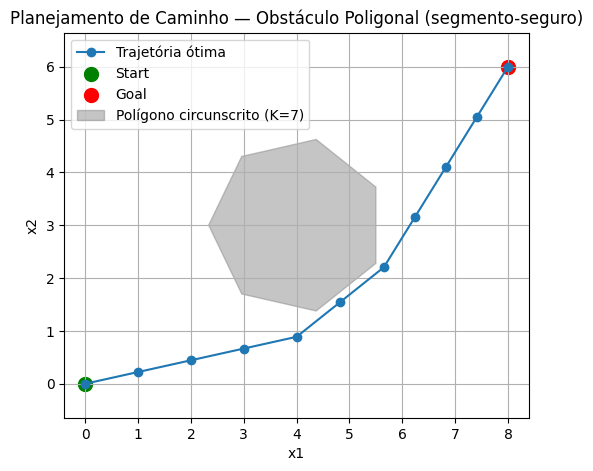

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB

# ---------------------
# PARÂMETROS
# ---------------------
T = 10
u_min, u_max = -1.0, 1.0
x_start = np.array([0.0, 0.0])
x_goal  = np.array([8.0, 6.0])

# Obstáculo circular (será aproximado por polígono circunscrito)
c = np.array([4.0, 3.0])   # centro
r = 1.5                    # raio
delta = 0.15               # "inflation"/clearance
R = r + delta

# Polígono circunscrito: K meias-planos tangentes
K = 7
thetas = np.linspace(0, 2*np.pi, K, endpoint=False)
H = np.column_stack((np.cos(thetas), np.sin(thetas)))   # normais (Kx2)
g = H @ c + R                                           # g_k = n_k^T c + R

# Big-M e folga numérica para ficar "fora"
M = 100.0
eps = 1e-3

# ---------------------
# MODELO GUROBI (MIQP)
# ---------------------
mdl = Model("M2_Polygonal_SegmentSafe")
mdl.setParam('OutputFlag', 0)

# Variáveis
x = mdl.addVars(T+1, 2, lb=-GRB.INFINITY, name="x")
u = mdl.addVars(T,   2, lb=u_min, ub=u_max, name="u")

# Binárias para a disjunção por segmento (t) e face (k)
b = mdl.addVars(T, K, vtype=GRB.BINARY, name="b")

# Objetivo: energia de controle
mdl.setObjective(sum(u[t,0]*u[t,0] + u[t,1]*u[t,1] for t in range(T)), GRB.MINIMIZE)

# Dinâmica: x_{t+1} = x_t + u_t
for t in range(T):
    mdl.addConstr(x[t+1,0] == x[t,0] + u[t,0])
    mdl.addConstr(x[t+1,1] == x[t,1] + u[t,1])

# Condições de contorno
mdl.addConstr(x[0,0] == x_start[0]); mdl.addConstr(x[0,1] == x_start[1])
mdl.addConstr(x[T,0] == x_goal[0]);  mdl.addConstr(x[T,1] == x_goal[1])

# Restrição de não colisão "segmento-seguro":
# para cada segmento t, escolher ao menos uma face k tal que x_t e x_{t+1} estejam no lado externo
for t in range(T):  # usa t e t+1
    mdl.addConstr(sum(b[t,k] for k in range(K)) >= 1, name=f"choose_face_t{t}")
    for k in range(K):
        a1, a2 = H[k,0], H[k,1]
        gk = float(g[k])
        # Mesma face k vale para as duas extremidades
        mdl.addConstr(a1*x[t,0]   + a2*x[t,1]   >= gk + eps - M*(1 - b[t,k]), name=f"sep_start_t{t}_k{k}")
        mdl.addConstr(a1*x[t+1,0] + a2*x[t+1,1] >= gk + eps - M*(1 - b[t,k]), name=f"sep_end_t{t}_k{k}")

# ---------------------
# RESOLUÇÃO
# ---------------------
mdl.optimize()
x_sol = np.array([[x[t,0].X, x[t,1].X] for t in range(T+1)])

# ---------------------
# PLOTAGEM
# ---------------------
# Vértices do polígono circunscrito (para visualização):
# lados tangentes em ângulos thetas => vértices em ângulos deslocados de pi/K, com raio R / cos(pi/K)
R_verts = r / np.cos(np.pi / K)
phi = thetas + (np.pi / K)
poly_x = c[0] + R_verts * np.cos(phi)
poly_y = c[1] + R_verts * np.sin(phi)

plt.figure(figsize=(6,5))
plt.plot(x_sol[:,0], x_sol[:,1], 'o-', label="Trajetória ótima")
plt.scatter(*x_start, c='green', s=100, label="Start")
plt.scatter(*x_goal,  c='red',   s=100, label="Goal")
plt.fill(poly_x, poly_y, color='gray', alpha=0.45, label=f"Polígono circunscrito (K={K})")
plt.xlabel("x1"); plt.ylabel("x2"); plt.axis("equal"); plt.grid(True)
plt.title("Planejamento de Caminho — Obstáculo Poligonal (segmento-seguro)")
plt.legend(); plt.show()
